In [63]:
from pathlib import Path
import pandas as pd

In [64]:
file_path = Path('./machine_temp_failure_missing.csv')

In [65]:
dat = pd.read_csv(file_path)

In [66]:
dat.head()

timestamp      value
0  02-12-2013 21:15  73.967322
1  02-12-2013 21:20  74.935882
2  02-12-2013 21:25  76.124162
3  02-12-2013 21:30  78.140707
4  02-12-2013 21:35  79.329836

In [67]:
missing_values = dat.isnull().sum()
print(missing_values)

timestamp       0
value        1285
dtype: int64


In [68]:
statistics = dat.describe()
print(statistics)

              value
count  21410.000000
mean      85.968188
std       13.553070
min        2.084721
25%       83.082867
50%       89.251290
75%       93.910748
max      108.510543


In [69]:
dat.rename(columns = {'value':'temperature'}, inplace = True)
dat.head()

timestamp  temperature
0  02-12-2013 21:15    73.967322
1  02-12-2013 21:20    74.935882
2  02-12-2013 21:25    76.124162
3  02-12-2013 21:30    78.140707
4  02-12-2013 21:35    79.329836

In [70]:
dat['delta_temperature'] = dat['temperature'].shift(-1) -dat['temperature']
dat.head()

timestamp  temperature  delta_temperature
0  02-12-2013 21:15    73.967322           0.968560
1  02-12-2013 21:20    74.935882           1.188280
2  02-12-2013 21:25    76.124162           2.016546
3  02-12-2013 21:30    78.140707           1.189128
4  02-12-2013 21:35    79.329836          -0.619417

In [71]:
import matplotlib.pyplot as plt

In [72]:
plt.figure(figsize = (10,5))
plt.plot(dat.index, dat['temperature'])
plt.title('Variation of Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')

Text(0, 0.5, 'Temperature')

In [73]:
plt.figure(figsize = (10,5))
plt.plot(dat.index, dat['delta_temperature'])
plt.title('Variation of delta_temperature')
plt.xlabel('Index')
plt.ylabel('delta_temperature')

Text(0, 0.5, 'delta_temperature')

Text(0, 0.5, 'Temperature')

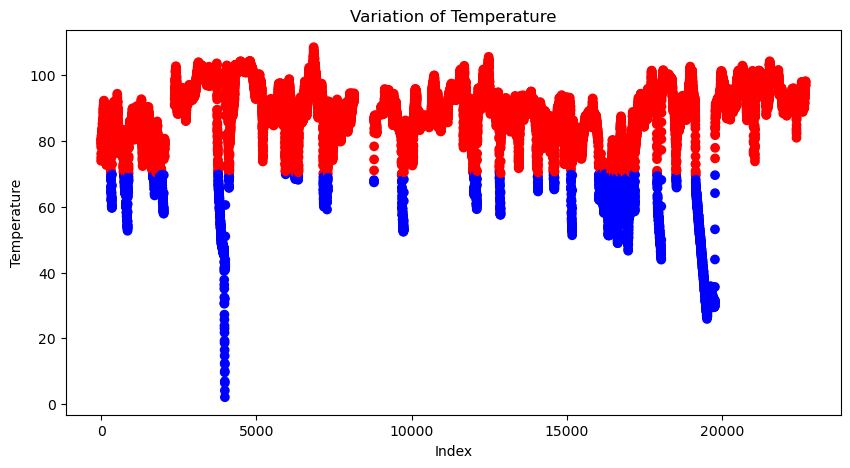

In [74]:
colors = ['red' if temp > 70.00 else 'blue' for temp in dat['temperature']]
plt.figure(figsize = (10,5))
plt.scatter(dat.index, dat['temperature'], c = colors)
plt.title('Variation of Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')


In [75]:
file_path = Path('./machine_temp_failure_original.csv')
data = pd.read_csv(file_path)

In [78]:
data.rename(columns = {'value':'temperature'}, inplace = True)

In [79]:
data.head()

timestamp  temperature
0  2013-12-02 21:15:00    73.967322
1  2013-12-02 21:20:00    74.935882
2  2013-12-02 21:25:00    76.124162
3  2013-12-02 21:30:00    78.140707
4  2013-12-02 21:35:00    79.329836

In [80]:
data.head()

timestamp  temperature
0  2013-12-02 21:15:00    73.967322
1  2013-12-02 21:20:00    74.935882
2  2013-12-02 21:25:00    76.124162
3  2013-12-02 21:30:00    78.140707
4  2013-12-02 21:35:00    79.329836

In [81]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

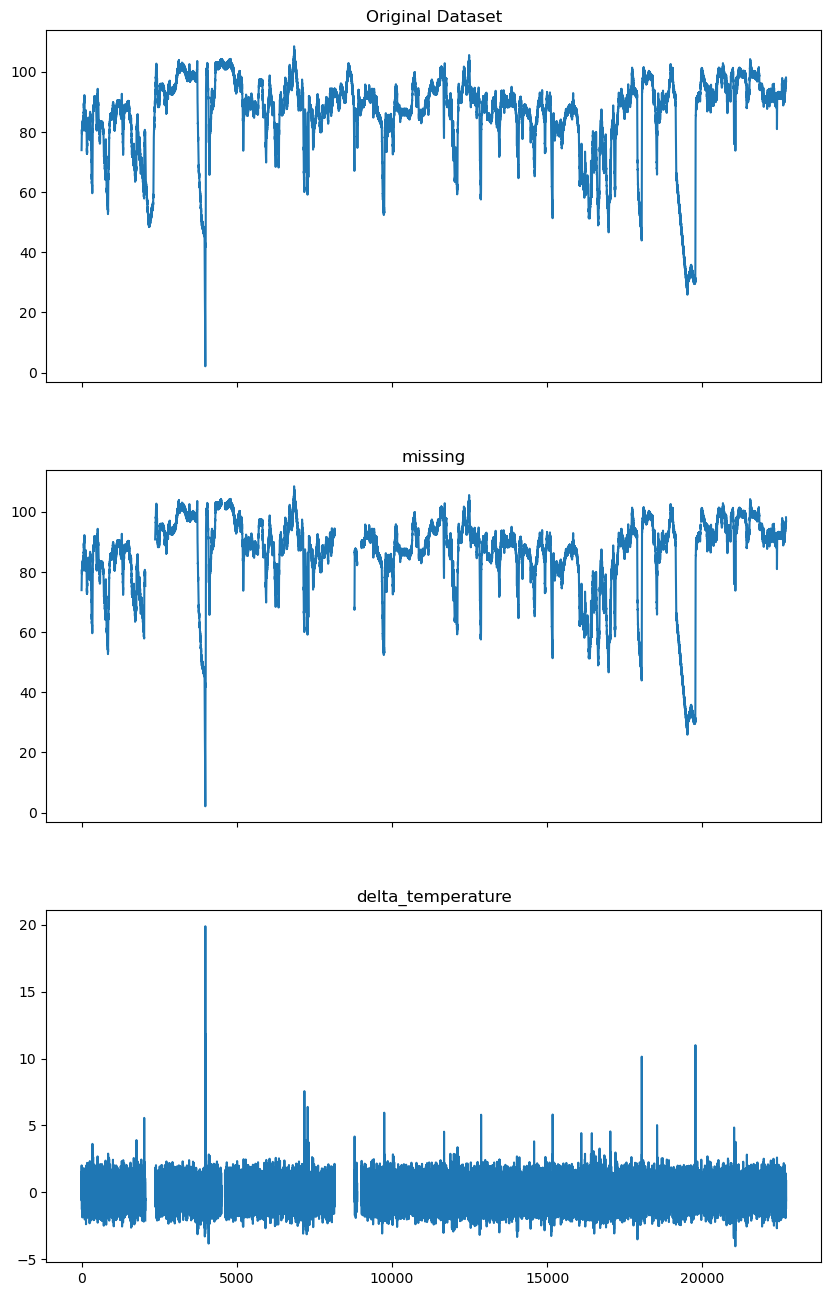

In [83]:
plot_dfs(data, dat, 'temperature')

In [84]:
import numpy as np
def rmse_score(df1, df2, col):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores

In [86]:
rmse_score(data, dat, col = 'temperature')

RMSE for delta_temperature: 87.03786338593693


[87.03786338593693]

In [87]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder / file, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [88]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [92]:
df = data.copy()

In [93]:
# Perform mean imputation using Pandas
df['temperature_mean'] = df['temperature'].fillna(df['temperature'].mean())

# Perform forward fill (ffill) imputation using Pandas
df['temperature_ffill'] = df['temperature'].fillna(method='ffill')

# Perform backward fill (bfill) imputation using Pandas
df['temperature_bfill'] = df['temperature'].fillna(method='bfill')

# Perform interpolation using Pandas
df['temperature_interpolate'] = df['temperature'].interpolate()

In [94]:
# Perform simple imputation using Scikit-Learn
imputer = SimpleImputer(strategy='mean')
df['temperature_imputed'] = imputer.fit_transform(df[['temperature']])

# Calculate RMSE scores
rmse_mean = np.sqrt(mean_squared_error(data['temperature'], df['temperature_mean']))
rmse_ffill = np.sqrt(mean_squared_error(data['temperature'], df['temperature_ffill']))
rmse_bfill = np.sqrt(mean_squared_error(data['temperature'], df['temperature_bfill']))
rmse_interpolate = np.sqrt(mean_squared_error(data['temperature'], df['temperature_interpolate']))
rmse_imputed = np.sqrt(mean_squared_error(data['temperature'], df['temperature_imputed']))


In [95]:
# Print RMSE scores
print(f"RMSE (Mean Imputation): {rmse_mean:.2f}")
print(f"RMSE (Forward Fill): {rmse_ffill:.2f}")
print(f"RMSE (Backward Fill): {rmse_bfill:.2f}")
print(f"RMSE (Interpolation): {rmse_interpolate:.2f}")
print(f"RMSE (Simple Imputer): {rmse_imputed:.2f}")

RMSE (Mean Imputation): 0.00
RMSE (Forward Fill): 0.00
RMSE (Backward Fill): 0.00
RMSE (Interpolation): 0.00
RMSE (Simple Imputer): 0.00


In [114]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Create a copy of the original dataset
df = data.copy()

# Perform mean imputation using Pandas
df['temperature_mean'] = df['temperature'].fillna(df['temperature'].mean())

# Perform forward fill (ffill) imputation using Pandas
df['temperature_ffill'] = df['temperature'].fillna(method='ffill')

# Perform backward fill (bfill) imputation using Pandas
df['temperature_bfill'] = df['temperature'].fillna(method='bfill')

# Perform interpolation using Pandas
df['temperature_interpolate'] = df['temperature'].interpolate()

# Perform simple imputation using Scikit-Learn
imputer = SimpleImputer(strategy='mean')
df['temperature_imputed'] = imputer.fit_transform(df[['temperature']])

# Calculate RMSE scores
rmse_mean = np.sqrt(mean_squared_error(data['temperature'], df['temperature_mean']))
rmse_ffill = np.sqrt(mean_squared_error(data['temperature'], df['temperature_ffill']))
rmse_bfill = np.sqrt(mean_squared_error(data['temperature'], df['temperature_bfill']))
rmse_interpolate = np.sqrt(mean_squared_error(data['temperature'], df['temperature_interpolate']))
rmse_imputed = np.sqrt(mean_squared_error(data['temperature'], df['temperature_imputed']))

# Print RMSE scores
print(f"RMSE (Mean Imputation): {rmse_mean:.2f}")
print(f"RMSE (Forward Fill): {rmse_ffill:.2f}")
print(f"RMSE (Backward Fill): {rmse_bfill:.2f}")
print(f"RMSE (Interpolation): {rmse_interpolate:.2f}")
print(f"RMSE (Simple Imputer): {rmse_imputed:.2f}")


RMSE (Mean Imputation): 0.00
RMSE (Forward Fill): 0.00
RMSE (Backward Fill): 0.00
RMSE (Interpolation): 0.00
RMSE (Simple Imputer): 0.00


In [116]:
# Determine the dataset with the least RMSE score
datasets = {
    'Mean Imputation': df['temperature_mean'],
    'Forward Fill': df['temperature_ffill'],
    'Backward Fill': df['temperature_bfill'],
    'Interpolation': df['temperature_interpolate'],
    'Simple Imputer': df['temperature_imputed']
}
min_rmse_dataset = min(datasets, key=datasets.get)

# Resample the dataset to hourly frequency
hourly_dataset = df[min_rmse_dataset].resample('H').mean()

# Convert the index to DatetimeIndex (if not already)
hourly_dataset.index = pd.to_datetime(hourly_dataset.index)

# Print the frequency of the original dataset and the resampled dataset
print("Original Dataset Frequency:")
print(pd.infer_freq(df.index))
print("\nResampled Dataset Frequency:")
print(hourly_dataset.index.freq)



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [118]:
data


timestamp  temperature
0      2013-12-02 21:15:00    73.967322
1      2013-12-02 21:20:00    74.935882
2      2013-12-02 21:25:00    76.124162
3      2013-12-02 21:30:00    78.140707
4      2013-12-02 21:35:00    79.329836
...                    ...          ...
22690  2014-02-19 15:05:00    98.185415
22691  2014-02-19 15:10:00    97.804168
22692  2014-02-19 15:15:00    97.135468
22693  2014-02-19 15:20:00    98.056852
22694  2014-02-19 15:25:00    96.903861

[22695 rows x 2 columns]

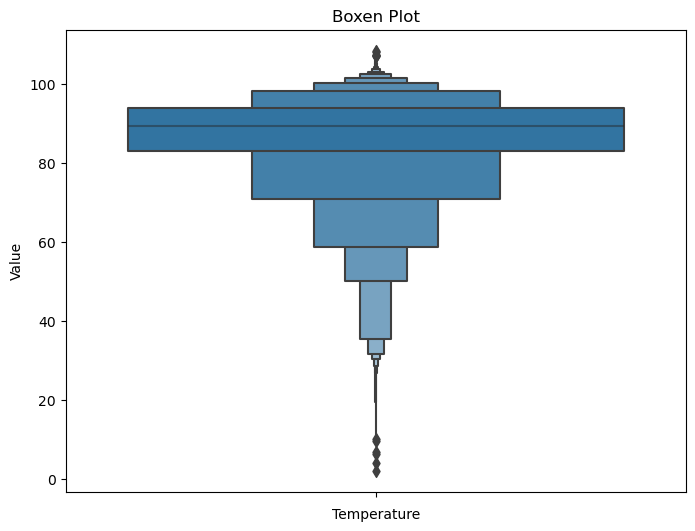

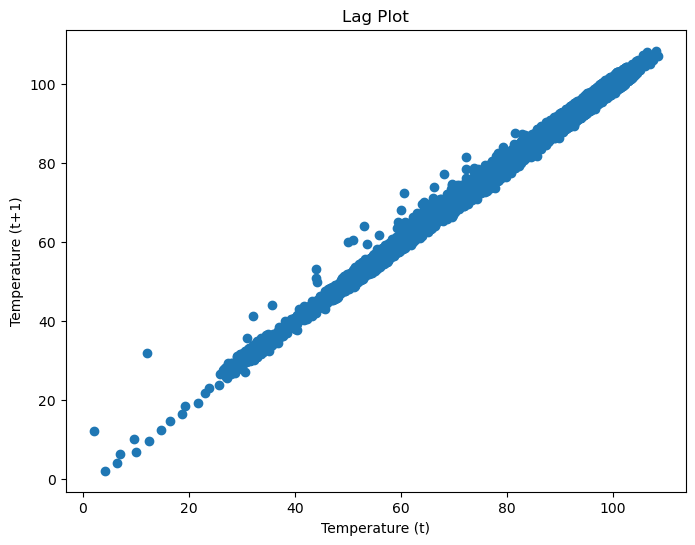

Outliers (IQR method):
320      65.906496
321      66.204651
322      66.094398
323      64.925151
324      65.910542
           ...    
19770    30.975528
19771    35.624129
19772    43.971303
19773    53.135749
19774    64.134769
Name: temperature, Length: 2298, dtype: float64


In [121]:
import seaborn as sns

# Box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data['temperature'])
plt.title('Box Plot')
plt.xlabel('Temperature')
plt.ylabel('Value')
plt.show()

# Boxen plot
plt.figure(figsize=(8, 6))
sns.boxenplot(data = data, y='temperature')
plt.title('Boxen Plot')
plt.xlabel('Temperature')
plt.ylabel('Value')
plt.show()

# Lag plot
plt.figure(figsize=(8, 6))
pd.plotting.lag_plot(data['temperature'])
plt.title('Lag Plot')
plt.xlabel('Temperature (t)')
plt.ylabel('Temperature (t+1)')
plt.show()

# Outlier detection using IQR method
def iqr_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Find outliers using IQR method
outliers_iqr = iqr_outliers(data['temperature'])
print("Outliers (IQR method):")
print(outliers_iqr)

# Compute z-scores
z_scores = zscore(data['temperature'])

# Plot z-scores
plt.figure(figsize=(8, 6))
plt.plot(z_scores, marker='o', linestyle='-', color='b')
plt.axhline(y=3, color='r', linestyle='--', label='Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Threshold (-3)')
plt.title('Z-Scores')
plt.xlabel('Data Point')
plt.ylabel('Z-Score')
plt.legend()
plt.show()
